In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, padding=1, usepool=True):
        super(Block, self).__init__()
        self.usepool = usepool
        self.conv1 = nn.Conv2d(input_size, output_size, 3, padding=padding)
        self.bn1 = nn.BatchNorm2d(output_size)
        self.conv2 = nn.Conv2d(output_size, output_size, 3, padding=padding)
        self.bn2 = nn.BatchNorm2d(output_size)
        if usepool:
            self.pool = nn.MaxPool2d(2, 2)
        
    def __call__(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        if self.usepool:
            x = self.pool(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.base_channels = 4
        self.drop = 0.01

        # Conv 
        self.block1 = Block(1, self.base_channels)
        self.dropout1 = nn.Dropout(self.drop)
        self.block2 = Block(self.base_channels, self.base_channels*2)
        self.dropout2 = nn.Dropout(self.drop)
        self.block3 = Block(self.base_channels*2, self.base_channels*4, usepool=False)
        self.dropout3 = nn.Dropout(self.drop)

        self.flat = nn.Conv2d(self.base_channels*4, 10, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x, dropout=True):
        # Conv Layer
        x = self.block1(x)
        if dropout:
            x = self.dropout1(x)
        x = self.block2(x)
        if dropout:
            x = self.dropout2(x)
        x = self.block3(x)
        if dropout:
            x = self.dropout3(x)

        # Output Layer
        x = self.flat(x)
        x = self.gap(x)
        x = x.view(-1, 10)

        # Output Layer
        return F.log_softmax(x, dim=1)

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 4, 28, 28]             148
       BatchNorm2d-4            [-1, 4, 28, 28]               8
         MaxPool2d-5            [-1, 4, 14, 14]               0
           Dropout-6            [-1, 4, 14, 14]               0
            Conv2d-7            [-1, 8, 14, 14]             296
       BatchNorm2d-8            [-1, 8, 14, 14]              16
            Conv2d-9            [-1, 8, 14, 14]             584
      BatchNorm2d-10            [-1, 8, 14, 14]              16
        MaxPool2d-11              [-1, 8, 7, 7]               0
          Dropout-12              [-1, 8, 7, 7]               0
           Conv2d-13             [-1, 16, 7, 7]           1,168
      BatchNorm2d-14             [-1, 1

In [4]:
torch.manual_seed(1)
batch_size = 64
random_rotation_degree = 5
img_size = (28, 28)
random_crop_percent = (0.85, 1.0)
random_affine_degrees = 5

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomResizedCrop(img_size, random_crop_percent),
                        transforms.RandomRotation(random_rotation_degree),
#                         transforms.RandomAffine(random_affine_degrees),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

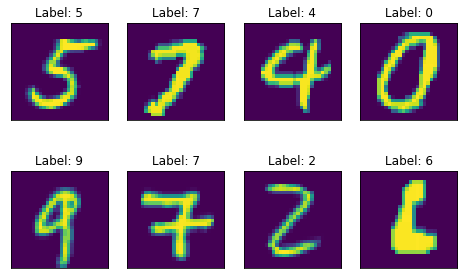

In [14]:
# Print Random Samples
for imgs, labels in train_loader:
    fig = plt.figure(figsize = (8, 5))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = []) 
        ax.set_title(f'Label: {labels[i]}')
        plt.imshow(imgs[i].numpy().transpose(1, 2, 0))
    break

In [6]:
def train(model, train_loader, optimizer, scheduler, epoch, dropout, device):
    model.train()
    epoch_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, dropout)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        epoch_loss += loss.item()
      
    return epoch_loss / len(train_loader), correct


def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    return test_loss, correct

In [7]:
import time
import math

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

model = Net().apply(initialize_weights).to(device)

# model = Net().to(device)

# Train Params
epochs = 12
lr = 0.001
max_lr = 0.01
steps_per_epoch = len(train_loader)
dropout = True

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("\n")

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs, anneal_strategy='linear')

# One cycle schedule with custome function
scheduler = np.interp(np.arange(epochs+1), [0, 2, 5, epochs], [lr, max_lr, lr/5.0, 0])

best_perc = 99.3
best_path = ""

def lr_schedules(epoch):
    return scheduler[epoch]

for epoch in range(epochs):
    # Manually assign lr
    optimizer.param_groups[0]['lr'] = lr_schedules(epoch)

    print(f'Epoch: {epoch+1:02}')
    print(f'\t Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    start_time = time.time()

    train_loss, train_correct = train(model, train_loader, optimizer, scheduler, epoch, dropout, device)
    valid_loss, valid_correct = test(model, test_loader, device)
    
    valid_perc = (100. * valid_correct / len(test_loader.dataset))
    
    if valid_perc >= best_perc:
        best_perc = valid_perc
        best_path = f'model_weights_{valid_perc:.2f}.pth'
        torch.save(model.state_dict(), best_path)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'\t          Time: {epoch_mins}m {epoch_secs}s');
    print(f'\t    Train Loss: {train_loss:.6f}')
    print(f'\tTrain Accuracy: {train_correct:5d}/{len(train_loader.dataset):5d} | Percent: {(100. * train_correct / len(train_loader.dataset)):.2f}%')
    print(f'\t     Val. Loss: {valid_loss:.6f}')
    print(f'\t  Val Accuracy: {valid_correct:5d}/{len(test_loader.dataset):5d} | Percent: {(100. * valid_correct / len(test_loader.dataset)):.2f}%')

Using Device: cuda
Epochs: 12
Lr: 0.001
Max Lr: 0.01
Batch Size: 64


Epoch: 01
	 Learning Rate: 0.001000
	          Time: 0m 8s
	    Train Loss: 0.625474
	Train Accuracy: 49858/60000 | Percent: 83.10%
	     Val. Loss: 0.162506
	  Val Accuracy:  9556/10000 | Percent: 95.56%
Epoch: 02
	 Learning Rate: 0.005500
	          Time: 0m 8s
	    Train Loss: 0.141658
	Train Accuracy: 57536/60000 | Percent: 95.89%
	     Val. Loss: 0.072401
	  Val Accuracy:  9770/10000 | Percent: 97.70%
Epoch: 03
	 Learning Rate: 0.010000
	          Time: 0m 7s
	    Train Loss: 0.099431
	Train Accuracy: 58192/60000 | Percent: 96.99%
	     Val. Loss: 0.062662
	  Val Accuracy:  9820/10000 | Percent: 98.20%
Epoch: 04
	 Learning Rate: 0.006733
	          Time: 0m 8s
	    Train Loss: 0.068084
	Train Accuracy: 58752/60000 | Percent: 97.92%
	     Val. Loss: 0.067833
	  Val Accuracy:  9795/10000 | Percent: 97.95%
Epoch: 05
	 Learning Rate: 0.003467
	          Time: 0m 8s
	    Train Loss: 0.051231
	Train Accuracy: 59044/60

In [13]:
model = Net().to(device)
model.load_state_dict(torch.load(best_path))
model.eval()

valid_loss, valid_correct = test(model, test_loader, device)

print(f'Val Accuracy: {valid_correct:4d}/{len(test_loader.dataset):5d}')
print(f'     Percent: {(100. * valid_correct / len(test_loader.dataset)):.2f}%')
print(f'   Val. Loss: {valid_loss:.6f}')

Val Accuracy: 9942/10000
     Percent: 99.42%
   Val. Loss: 0.021877


## Analyze Network

In [9]:
def get_predictions(model, loader, device):
    model.eval()
    all_preds = torch.tensor([]).to(device)
    all_targets = torch.tensor([]).to(device)
    with torch.no_grad():
        for data, target in loader:
            data, targets = data.to(device), target.to(device)
            all_targets = torch.cat(
                (all_targets, targets),
                dim=0
            )
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds = torch.cat(
                (all_preds, preds),
                dim=0
            ) 
    
    return all_preds, all_targets

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.type(torch.float32) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


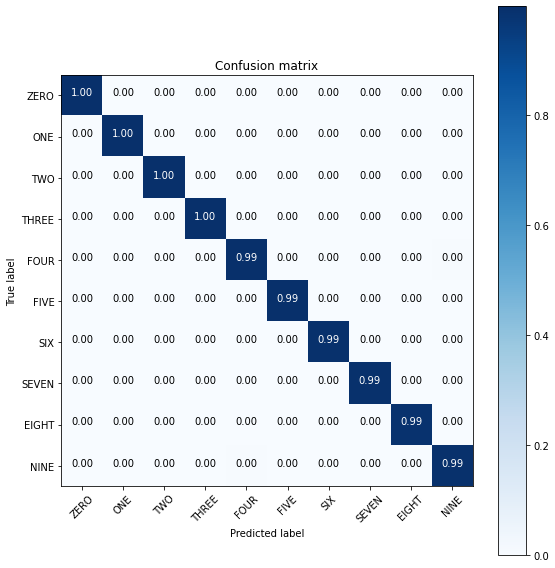

In [10]:
# Calculate predictions and targets
all_preds, all_targets = get_predictions(model, test_loader, device)
stacked = torch.stack((
        all_targets, all_preds
    ),
    dim=1
).type(torch.int64)

no_classes = 10

# Create temp confusion matrix
cmt = torch.zeros(no_classes, no_classes, dtype=torch.int64)

# Fill up confusion matrix with actual values
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
    
# Create class map
class_map = {
    'ZERO': 0,
    'ONE': 1,
    'TWO': 2,
    'THREE': 3,
    'FOUR': 4,
    'FIVE': 5,
    'SIX': 6,
    'SEVEN': 7,
    'EIGHT': 8,
    'NINE': 9
}
    
plt.figure(figsize=(8,8))
plot_confusion_matrix(cmt, class_map, True)

In [11]:
def get_incorrrect_predictions(model, loader, device):
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append([d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])
    
    return incorrect

incorrect = get_incorrrect_predictions(model, test_loader, device)

Total Incorrect Predictions 58


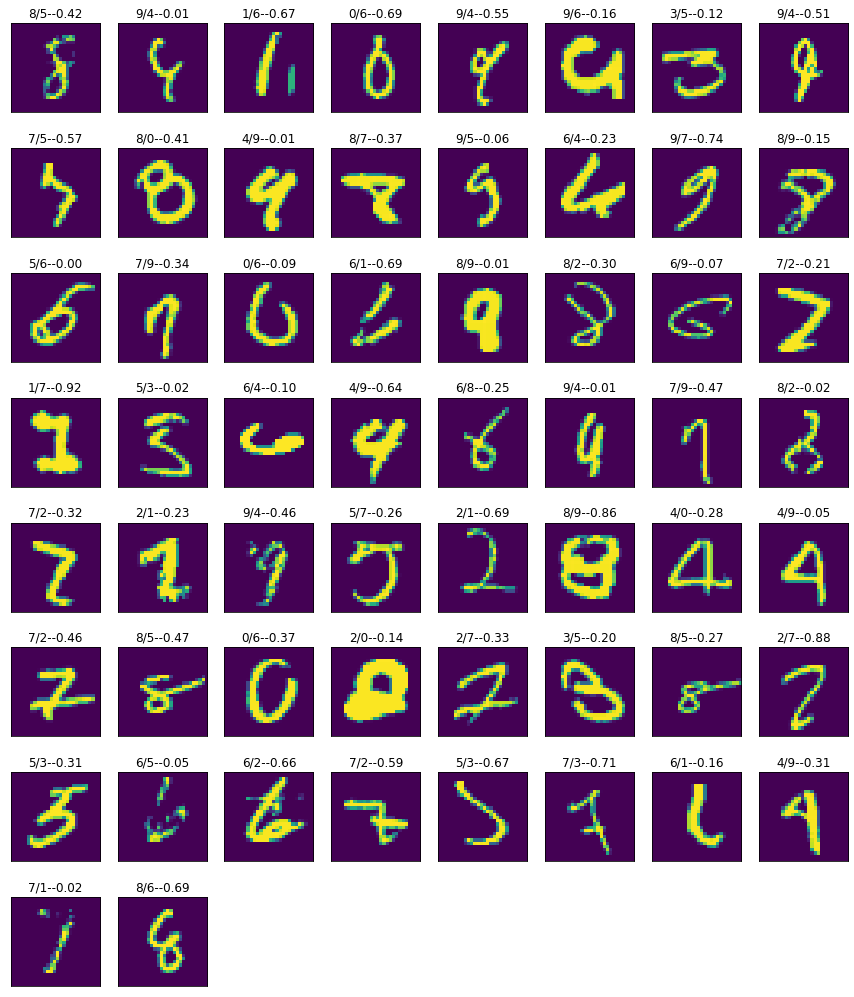

In [12]:
print(f'Total Incorrect Predictions {len(incorrect)}')

classes = list(class_map.values())

fig = plt.figure(figsize = (15, 18))
for i, (d, t, p, o) in enumerate(incorrect):
    ax = fig.add_subplot(8, 8, i + 1, xticks = [], yticks = [])
    ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}-{o:.2f}')
    plt.imshow(d.cpu().numpy().transpose(1, 2, 0))